In [1]:
# Verify CUDA availability
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
NVIDIA GeForce RTX 4070 Ti SUPER


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch.nn as nn

In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print (device)

cuda:1


In [4]:
%matplotlib inline

In [5]:
%ls

 Volume in drive C is System
 Volume Serial Number is 56BE-7538

 Directory of C:\Users\pham\lame horse

03/07/2024  09:05    <DIR>          .
03/07/2024  09:05    <DIR>          ..
02/07/2024  16:48    <DIR>          .ipynb_checkpoints
02/07/2024  16:45    <DIR>          data
02/07/2024  21:19    <DIR>          dataset
03/07/2024  09:05           295,036 feature extraction model.ipynb
03/07/2024  00:57            70,818 lame horse
02/07/2024  16:45    <DIR>          sound_horse-20240702T143913Z-001
02/07/2024  16:40           294,374 training loop.ipynb
02/07/2024  16:36             2,833 Untitled.ipynb
02/07/2024  16:39           192,328 Untitled0.ipynb
02/07/2024  16:39           867,137 yolo best model.ipynb
02/07/2024  16:39           684,864 YOLO retrain.ipynb
               7 File(s)      2,407,390 bytes
               6 Dir(s)  387,974,332,416 bytes free


In [6]:
import torchvision.transforms as transforms
from torchvision import datasets
from PIL import Image
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import time
import cv2

In [8]:
class VideoDataset(Dataset):
    def __init__(self, video_paths, labels, transform=None):
        self.video_paths = video_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        cap = cv2.VideoCapture(video_path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)
            if self.transform:
              frame = self.transform(frame)
            frames.append(frame)
        cap.release()
        frames = torch.stack(frames, dim=0)
        frames = frames.permute(1, 0, 2, 3)
        labels = self.labels[idx]

        return frames, labels


In [9]:
def get_video_paths_and_labels(root_dir):
    video_paths = []
    labels = []
    class_names = sorted(os.listdir(root_dir))
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

    print(f"class names: {class_names}")
    print(f"mapping index to class names: {class_to_idx} ")
    for cls_name in class_names:
        cls_dir = os.path.join(root_dir, cls_name)
        print(f"Checking directory: {cls_dir}")
        if os.path.isdir(cls_dir):  # Check if it's a directory
            for filename in os.listdir(cls_dir):
                if filename.endswith(('.mp4', '.avi', '.mov')):
                    video_path = os.path.join(cls_dir, filename)
                    video_paths.append(video_path)
                    labels.append(class_to_idx[cls_name])
                    print(f"Found video: {video_path}, label: {class_to_idx[cls_name]}")
                else:
                    print(f"Skipping non-video file: {filename}")

    return video_paths, labels

In [10]:
train_path = 'dataset/train'
video_path, labels = get_video_paths_and_labels(train_path)

class names: ['lame', 'sound']
mapping index to class names: {'lame': 0, 'sound': 1} 
Checking directory: dataset/train\lame
Found video: dataset/train\lame\1.mp4, label: 0
Found video: dataset/train\lame\2.mp4, label: 0
Found video: dataset/train\lame\3.mp4, label: 0
Found video: dataset/train\lame\4.mp4, label: 0
Found video: dataset/train\lame\5.mp4, label: 0
Skipping non-video file: download.jpg
Skipping non-video file: horse-4062214.webp
Skipping non-video file: lame-horse-1.webp
Skipping non-video file: tt-blog-3.jpg
Checking directory: dataset/train\sound
Found video: dataset/train\sound\2122952-hd_1280_720_60fps.mp4, label: 1
Found video: dataset/train\sound\2865004-hd_1280_720_30fps.mp4, label: 1
Found video: dataset/train\sound\2865027-hd_1280_720_30fps.mp4, label: 1
Skipping non-video file: Copy of 11-Black-and-White-Horse-Breeds-with-_jpg.rf.bf221ecf541b08703e4bb3b4fc504d29(1).jpg
Skipping non-video file: Copy of 11-Black-and-White-Horse-Breeds-with-_jpg.rf.bf221ecf541b0870

In [11]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = VideoDataset(video_path, labels, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, pin_memory = True)


In [ ]:
def visualize_batch_from_dataloader(dataloader):
    batch = next(iter(dataloader))
    frames, labels = batch
    frames = frames[0]  # Take the first video in the batch

    fig, axes = plt.subplots(1, min(frames.size(0), 5), figsize=(20, 5))
    for i in range(min(frames.size(0), 5)):
        frame = frames[i]  # Extract each frame
        # frame = frame.permute(1, 2, 0)  # Convert CHW to HWC for visualization
        frame = frame * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Denormalize
        axes[i].imshow(frame.numpy())
        axes[i].axis('off')
    plt.show()

visualize_batch_from_dataloader(train_loader)

In [15]:
def print_batch_shapes(dataloader):
    batch = next(iter(dataloader))
    frames, labels = batch
    print(f"Frames shape: {frames.shape}")  # Shape of frames tensor
    print(f"Labels shape: {labels.shape}")  # Shape of labels tensor
print_batch_shapes(train_loader)

Frames shape: torch.Size([1, 3, 210, 224, 224])
Labels shape: torch.Size([1])


In [13]:
torch.cuda.empty_cache()

In [14]:
# Check CUDA availability
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(0))  # Print the name of the GPU
else:
    device = torch.device('cpu')
    print('CUDA is not available. Using CPU.')

# Move tensors to GPU (if available)
tensor = torch.randn(3, 3).to(device)


NVIDIA GeForce RTX 4070 Ti SUPER


In [16]:
!nvidia-smi

Tue Jul  2 20:39:41 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...  WDDM  |   00000000:3C:00.0 Off |                  N/A |
|  0%   31C    P8              1W /  285W |     211MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
import torch.nn as nn

class SimpleConv3D(nn.Module):
    def __init__(self):
        super(SimpleConv3D, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv3d(3, 16, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
        )

        # Flatten and classify
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(16,2)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [ ]:
pip install torchinfo

In [18]:
from torchinfo import summary
model = SimpleConv3D()
input_shape = (1,3,773,224,224)
summary(model, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
SimpleConv3D                             [1, 2]                    --
├─Sequential: 1-1                        [1, 16, 386, 112, 112]    --
│    └─Conv3d: 2-1                       [1, 16, 773, 224, 224]    1,312
│    └─BatchNorm3d: 2-2                  [1, 16, 773, 224, 224]    32
│    └─ReLU: 2-3                         [1, 16, 773, 224, 224]    --
│    └─MaxPool3d: 2-4                    [1, 16, 386, 112, 112]    --
├─AdaptiveAvgPool3d: 1-2                 [1, 16, 1, 1, 1]          --
├─Linear: 1-3                            [1, 2]                    34
Total params: 1,378
Trainable params: 1,378
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 50.89
Input size (MB): 465.43
Forward/backward pass size (MB): 9929.23
Params size (MB): 0.01
Estimated Total Size (MB): 10394.67

In [21]:
val_path = 'dataset/val'
val_video_paths, val_labels = get_video_paths_and_labels(val_path)

class names: ['lame', 'sound']
mapping index to class names: {'lame': 0, 'sound': 1} 
Checking directory: dataset/val\lame
Found video: dataset/val\lame\2.mp4, label: 0
Checking directory: dataset/val\sound
Found video: dataset/val\sound\2122952-hd_1280_720_60fps.mp4, label: 1


In [22]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_dataset = VideoDataset(val_video_paths, val_labels, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, pin_memory=True)


In [23]:
def print_batch_shapes(dataloader):
    batch = next(iter(dataloader))
    frames, labels = batch
    print(f"Frames shape: {frames.shape}")  # Shape of frames tensor
    print(f"Labels shape: {labels.shape}")  # Shape of labels tensor
print_batch_shapes(val_loader)

Frames shape: torch.Size([1, 3, 210, 224, 224])
Labels shape: torch.Size([1])


In [24]:
import matplotlib.pyplot as plt

# Initialize the model, criterion, and optimizer
model = SimpleConv3D().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []

NUM_EPOCHS = 3
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    for videos, labels in train_loader:
        videos = videos.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for videos, labels in val_loader:
            videos = videos.to(device)
            labels = labels.to(device)
            outputs = model(videos)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

print("Training finished!")


Epoch [1/3], Train Loss: 0.6838, Val Loss: 0.7184, Val Accuracy: 0.5000
Epoch [2/3], Train Loss: 0.6654, Val Loss: 0.7247, Val Accuracy: 0.5000
Epoch [3/3], Train Loss: 0.6591, Val Loss: 0.7261, Val Accuracy: 0.5000
Training finished!


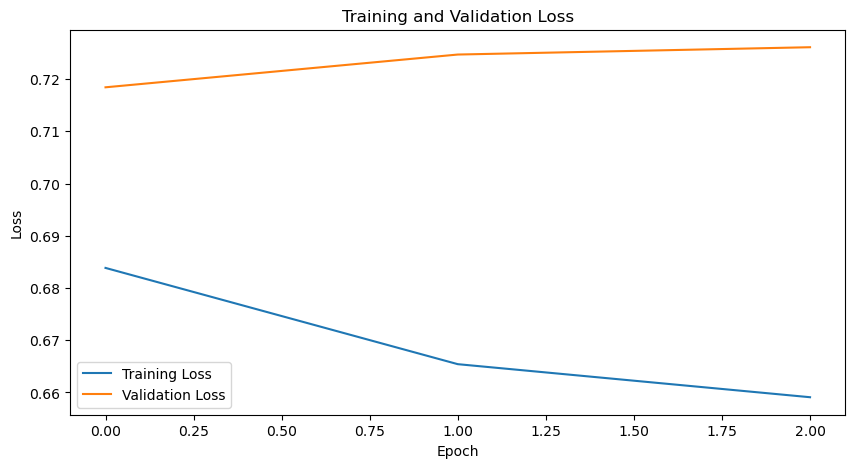

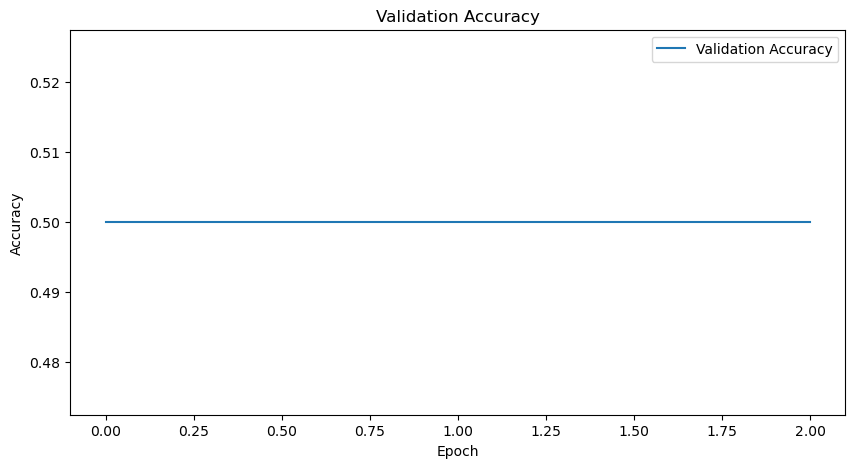

In [25]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()


In [28]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv_layers.0.weight 	 torch.Size([16, 3, 3, 3, 3])
conv_layers.0.bias 	 torch.Size([16])
conv_layers.1.weight 	 torch.Size([16])
conv_layers.1.bias 	 torch.Size([16])
conv_layers.1.running_mean 	 torch.Size([16])
conv_layers.1.running_var 	 torch.Size([16])
conv_layers.1.num_batches_tracked 	 torch.Size([])
fc.weight 	 torch.Size([2, 16])
fc.bias 	 torch.Size([2])
Optimizer's state_dict:
state 	 {0: {'step': tensor(24.), 'exp_avg': tensor([[[[[ 1.4677e-03,  1.3256e-04, -1.2235e-04],
           [ 9.7577e-04, -1.1654e-04, -3.9944e-04],
           [ 6.2557e-04, -2.1933e-04, -7.0415e-04]],

          [[ 1.2214e-03, -1.2622e-06, -2.8854e-04],
           [ 6.8796e-04, -2.1208e-04, -3.8501e-04],
           [ 3.7588e-04, -1.9301e-04, -5.2623e-04]],

          [[ 8.8308e-04, -8.3233e-04, -9.0981e-04],
           [ 1.5807e-04, -1.2574e-03, -1.0970e-03],
           [-2.4219e-04, -1.1534e-03, -1.1315e-03]]],


         [[[ 1.1551e-03, -8.1540e-05, -2.7125e-04],
           [ 7.

In [ ]:
torch.save(model, PATH)

old code below

In [ ]:
# Save model and optimizer states after initial training
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': running_loss,
}, 'lame horse')


saving the model

In [31]:
model_save_path = 'lame horse'
torch.save(model.state_dict(), model_save_path)

print(f"Model state dictionary saved to {model_save_path}")
torch.save(model, model_save_path)

print(f"Entire model saved to {model_save_path}")


Model state dictionary saved to lame horse
Entire model saved to lame horse


In [32]:
import torch

# Check GPU availability
if torch.cuda.is_available():
    # Print GPU memory stats
    print(torch.cuda.memory_summary(device=None, abbreviated=False))
else:
    print("CUDA is not available. Check if GPU is enabled in your Colab runtime.")


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 420642 KiB |  22193 MiB | 304878 MiB | 304467 MiB |
|       from large pool | 420596 KiB |  22193 MiB | 304876 MiB | 304465 MiB |
|       from small pool |     46 KiB |      0 MiB |      1 MiB |      1 MiB |
|---------------------------------------------------------------------------|
| Active memory         | 420642 KiB |  22193 MiB | 304878 MiB | 304467 MiB |
|       from large pool | 420596 KiB |  22193 MiB | 304876 MiB |

In [ ]:
import torch
import cv2
from torchvision import transforms
from PIL import Image

test_video_path = 'lame horse/dataset/test'

# Define transformation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to load and preprocess video
def load_and_preprocess_video(video_path, transform):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame)
        frame = transform(frame)
        frames.append(frame)
    cap.release()
    frames = torch.stack(frames, dim=0)
    frames = frames.permute(1, 0, 2, 3)
    return frames.unsqueeze(0)  # Add batch dimension

# Load and preprocess the video
video_tensor = load_and_preprocess_video(test_video_path, test_transform)
video_tensor = video_tensor.to(device)

# Load the model
model = SimpleConv3D()
model.load_state_dict(torch.load('/content/gdrive/MyDrive/ARPA/model2.pth'))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Run the model on the test video
with torch.no_grad():
    output = model(video_tensor)
    print (f"raw output: {output}")
    _, predicted = torch.max(output, 1)

print(f'Predicted label: {predicted.item()}')
print(f"output shape:")


In [ ]:
# create deeper model

In [7]:
import torch.nn as nn

class Conv3D_2L(nn.Module):
    def __init__(self):
        super(Conv3D_2L, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv3d(3, 16, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),

            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
        )

        # Flatten and classify
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(32,2)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [9]:
from torchinfo import summary
model = Conv3D_2L()
input_shape = (1,3,773,224,224)
summary(model, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
Conv3D_2L                                [1, 2]                    --
├─Sequential: 1-1                        [1, 32, 193, 56, 56]      --
│    └─Conv3d: 2-1                       [1, 16, 773, 224, 224]    1,312
│    └─BatchNorm3d: 2-2                  [1, 16, 773, 224, 224]    32
│    └─ReLU: 2-3                         [1, 16, 773, 224, 224]    --
│    └─MaxPool3d: 2-4                    [1, 16, 386, 112, 112]    --
│    └─Conv3d: 2-5                       [1, 32, 386, 112, 112]    13,856
│    └─BatchNorm3d: 2-6                  [1, 32, 386, 112, 112]    64
│    └─ReLU: 2-7                         [1, 32, 386, 112, 112]    --
│    └─MaxPool3d: 2-8                    [1, 32, 193, 56, 56]      --
├─AdaptiveAvgPool3d: 1-2                 [1, 32, 1, 1, 1]          --
├─Linear: 1-3                            [1, 2]                    66
Total params: 15,330
Trainable params: 15,330
Non-trainable params: 0
Total mu

In [40]:
import matplotlib.pyplot as plt

# Initialize the model, criterion, and optimizer
model = Conv3D_2L().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []

NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    for videos, labels in train_loader:
        videos = videos.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for videos, labels in val_loader:
            videos = videos.to(device)
            labels = labels.to(device)
            outputs = model(videos)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

print("Training finished!")


Epoch [1/10], Train Loss: 0.7022, Val Loss: 0.6811, Val Accuracy: 0.5000
Epoch [2/10], Train Loss: 0.6544, Val Loss: 0.6864, Val Accuracy: 0.5000
Epoch [3/10], Train Loss: 0.6470, Val Loss: 0.6959, Val Accuracy: 0.5000
Epoch [4/10], Train Loss: 0.6347, Val Loss: 0.6912, Val Accuracy: 0.5000
Epoch [5/10], Train Loss: 0.6253, Val Loss: 0.6657, Val Accuracy: 0.5000
Epoch [6/10], Train Loss: 0.6238, Val Loss: 0.6731, Val Accuracy: 0.5000
Epoch [7/10], Train Loss: 0.6099, Val Loss: 0.6738, Val Accuracy: 0.5000
Epoch [8/10], Train Loss: 0.6124, Val Loss: 0.6859, Val Accuracy: 0.5000
Epoch [9/10], Train Loss: 0.6028, Val Loss: 0.6662, Val Accuracy: 0.5000
Epoch [10/10], Train Loss: 0.5888, Val Loss: 0.6590, Val Accuracy: 0.5000
Training finished!


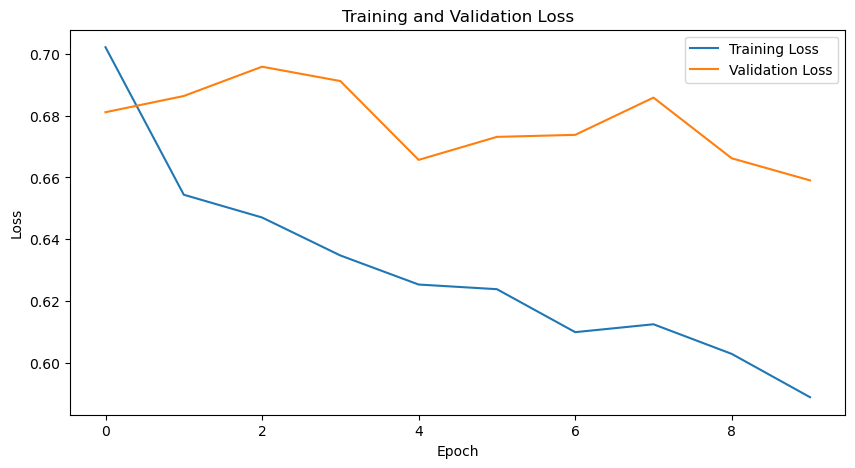

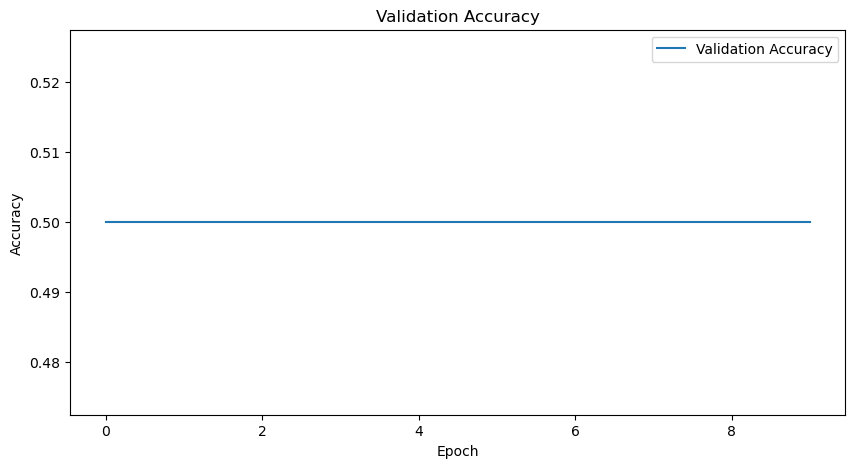

In [41]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()


In [42]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv_layers.0.weight 	 torch.Size([16, 3, 3, 3, 3])
conv_layers.0.bias 	 torch.Size([16])
conv_layers.1.weight 	 torch.Size([16])
conv_layers.1.bias 	 torch.Size([16])
conv_layers.1.running_mean 	 torch.Size([16])
conv_layers.1.running_var 	 torch.Size([16])
conv_layers.1.num_batches_tracked 	 torch.Size([])
conv_layers.4.weight 	 torch.Size([32, 16, 3, 3, 3])
conv_layers.4.bias 	 torch.Size([32])
conv_layers.5.weight 	 torch.Size([32])
conv_layers.5.bias 	 torch.Size([32])
conv_layers.5.running_mean 	 torch.Size([32])
conv_layers.5.running_var 	 torch.Size([32])
conv_layers.5.num_batches_tracked 	 torch.Size([])
fc.weight 	 torch.Size([2, 32])
fc.bias 	 torch.Size([2])
Optimizer's state_dict:
state 	 {0: {'step': tensor(80.), 'exp_avg': tensor([[[[[-6.2732e-06, -1.9619e-04, -7.4312e-04],
           [ 3.7790e-05, -5.1514e-04, -9.9146e-04],
           [-2.0990e-04,  2.2457e-04, -3.8986e-04]],

          [[-4.6049e-04, -1.7607e-04, -1.5473e-04],
           [-1.7935e-0

In [43]:
model_save_path = 'lame horse'
torch.save(model.state_dict(), model_save_path)

print(f"Model state dictionary saved to {model_save_path}")
torch.save(model, model_save_path)

print(f"Entire model saved to {model_save_path}")


Model state dictionary saved to lame horse
Entire model saved to lame horse
